# Project Description

**I'm developing a machine learning model to predict sleep quality (good or bad) using data collected from Fitbit devices. The model analyzes key activity and health related features such as active minutes, distance, and calories burned to determine overall sleep quality.**

# Import Dependencies

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score



# Data Collection

In [2]:
# Load datasets
activity = pd.read_csv('/kaggle/input/sleep1/dailyActivity_merged.csv')
sleep = pd.read_csv('/kaggle/input/sleep1/sleepDay_merged.csv')

# Convert date columns to same format
activity['ActivityDate'] = pd.to_datetime(activity['ActivityDate'])
sleep['SleepDay'] = pd.to_datetime(sleep['SleepDay'])

# Merge on Id and Date
merged = pd.merge(activity, sleep, how='inner', left_on=['Id', 'ActivityDate'], right_on=['Id', 'SleepDay'])

# Drop duplicate date column
merged.drop(columns=['SleepDay'], inplace=True)

# Chech result
merged.head()

/tmp/ipykernel_13/1278729107.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sleep['SleepDay'] = pd.to_datetime(sleep['SleepDay'])


,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed
0,1503960366,2016-04-12,13162,8.50,8.50,0.0,1.88,0.55,6.06,0.0,25,13,328,728,1985,1,327,346
1,1503960366,2016-04-13,10735,6.97,6.97,0.0,1.57,0.69,4.71,0.0,21,19,217,776,1797,2,384,407
2,1503960366,2016-04-15,9762,6.28,6.28,0.0,2.14,1.26,2.83,0.0,29,34,209,726,1745,1,412,442
3,1503960366,2016-04-16,12669,8.16,8.16,0.0,2.71,0.41,5.04,0.0,36,10,221,773,1863,2,340,367
4,1503960366,2016-04-17,9705,6.48,6.48,0.0,3.19,0.78,2.51,0.0,38,20,164,539,1728,1,700,712


In [3]:
# Number of rows and columns
merged.shape

(413, 18)

# Create the target variable

**To define the target variable for sleep quality, I calculated Sleep Efficiency as the ratio of total minutes asleep to total time in bed. Based on recommendations from sleep research and clinical guidelines (e.g., National Sleep Foundation), I set a threshold of 85%: sleep quality is labeled as good (1) if efficiency is ≥ 85%, and bad (0) otherwise.**

In [4]:
# Create Sleep Efficiency column
merged['SleepEfficiency'] = merged['TotalMinutesAsleep'] / merged['TotalTimeInBed']

# Create binary label
merged['SleepQuality'] = merged['SleepEfficiency'].apply(lambda x: 1 if x >= 0.85 else 0)

# Check distribution 
merged['SleepQuality'].value_counts()

SleepQuality
1    380
0     33
Name: count, dtype: int64

In [5]:
# Display first five rows
merged.head()

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed,SleepEfficiency,SleepQuality
0,1503960366,2016-04-12,13162,8.50,8.50,0.0,1.88,0.55,6.06,0.0,25,13,328,728,1985,1,327,346,0.945087,1
1,1503960366,2016-04-13,10735,6.97,6.97,0.0,1.57,0.69,4.71,0.0,21,19,217,776,1797,2,384,407,0.943489,1
2,1503960366,2016-04-15,9762,6.28,6.28,0.0,2.14,1.26,2.83,0.0,29,34,209,726,1745,1,412,442,0.932127,1
3,1503960366,2016-04-16,12669,8.16,8.16,0.0,2.71,0.41,5.04,0.0,36,10,221,773,1863,2,340,367,0.926431,1
4,1503960366,2016-04-17,9705,6.48,6.48,0.0,3.19,0.78,2.51,0.0,38,20,164,539,1728,1,700,712,0.983146,1


# Feature Selection

**I decided to drop the ID and ActivityDate columns from the dataset, as they do not carry meaningful information for predicting sleep quality and could introduce unnecessary noise into the model.**

In [6]:
# Drop ID, Dates, and Leakage Columns

columns_to_drop = [
    'Id',                   # Use identifier
    'ActivityDate',         # Data (used only for merging)
]  

# Drop the columns

cleaned = merged.drop(columns = columns_to_drop, errors = 'ignore')

# Drop duplicates if any

cleaned = cleaned.drop_duplicates()

cleaned.head(100)

,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed,SleepEfficiency,SleepQuality
0,13162,8.50,8.50,0.0,1.88,0.55,6.06,0.0,25,13,328,728,1985,1,327,346,0.945087,1
1,10735,6.97,6.97,0.0,1.57,0.69,4.71,0.0,21,19,217,776,1797,2,384,407,0.943489,1
2,9762,6.28,6.28,0.0,2.14,1.26,2.83,0.0,29,34,209,726,1745,1,412,442,0.932127,1
3,12669,8.16,8.16,0.0,2.71,0.41,5.04,0.0,36,10,221,773,1863,2,340,367,0.926431,1
4,9705,6.48,6.48,0.0,3.19,0.78,2.51,0.0,38,20,164,539,1728,1,700,712,0.983146,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,11388,7.62,7.62,0.0,0.45,4.22,2.95,0.0,7,95,170,797,1551,1,250,371,0.673854,0
96,7193,5.04,5.04,0.0,0.00,0.42,4.62,0.0,0,10,176,714,1377,1,349,540,0.646296,0
97,7114,4.88,4.88,0.0,1.37,0.29,3.22,0.0,15,8,190,804,1407,1,261,423,0.617021,0
98,10645,7.75,7.75,0.0,3.74,1.30,2.71,0.0,36,32,150,744,1545,1,333,478,0.696653,0


# Check correlation

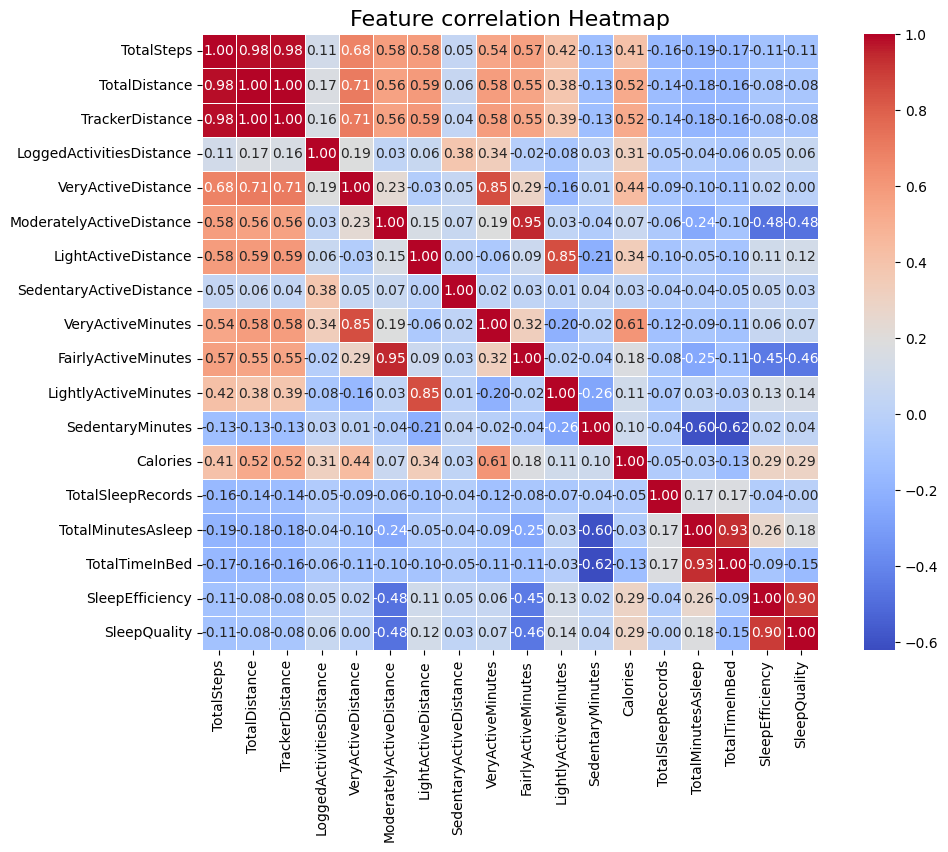

In [7]:
# Compute the correlation matrix
corr_matrix = cleaned.corr()

# Set the figure size and plot the heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot = True, fmt=".2f", cmap='coolwarm', square = True,linewidth = 0.5)

# Add a title
plt.title("Feature correlation Heatmap", fontsize = 16)
plt.show()

# Define features and target

In [8]:
X = cleaned.drop(columns = ['SleepQuality', 'SleepEfficiency','TotalTimeInBed','TotalMinutesAsleep','LoggedActivitiesDistance'])
y = cleaned['SleepQuality']

In [9]:
X

,TotalSteps,TotalDistance,TrackerDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories,TotalSleepRecords
0,13162,8.50,8.50,1.88,0.55,6.06,0.0,25,13,328,728,1985,1
1,10735,6.97,6.97,1.57,0.69,4.71,0.0,21,19,217,776,1797,2
2,9762,6.28,6.28,2.14,1.26,2.83,0.0,29,34,209,726,1745,1
3,12669,8.16,8.16,2.71,0.41,5.04,0.0,36,10,221,773,1863,2
4,9705,6.48,6.48,3.19,0.78,2.51,0.0,38,20,164,539,1728,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,7174,4.59,4.59,0.33,0.36,3.91,0.0,10,20,301,749,2896,1
409,1619,1.04,1.04,0.00,0.00,1.04,0.0,0,0,79,834,1962,1
410,1831,1.17,1.17,0.00,0.00,1.17,0.0,0,0,101,916,2015,1
411,2421,1.55,1.55,0.00,0.00,1.55,0.0,0,0,156,739,2297,1


In [10]:
y

0      1
1      1
2      1
3      1
4      1
      ..
408    1
409    1
410    1
411    1
412    1
Name: SleepQuality, Length: 410, dtype: int64

# Split the Dataset

**I used train-test split to divide the dataset into two parts: a training set to train the machine learning model, and a test set to evaluate its performance on unseen data. This helps ensure the model generalizes well and avoids overfitting.**

In [11]:
# Split with stratify to maintain class balance

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Logistic Regression

**Scale the features**

**Feature scaling is an important preprocessing step in logistic regression. It ensures that all input features are on a similar scale, especially when they have different units or ranges. Without scaling, features with larger values can dominate the model and affect the training process. Scaling helps improve the model's convergence speed and performance.**


In [12]:
# Initialize the scaler

scaler = StandardScaler()

# Fit only on training data, transform both train and test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)






In [13]:
# Create and train the model
lr_model = LogisticRegression(random_state = 42)
lr_model.fit(X_train_scaled, y_train)


LogisticRegression(random_state=42)

**Make predictions**

In [14]:
y_pred_lr = lr_model.predict(X_train_scaled)

**Evaluate the model based on test data**

In [15]:
y_pred_lr = lr_model.predict(X_test_scaled)

In [16]:
# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred_lr))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred_lr))


Accuracy: 0.9390243902439024
Confusion Matrix:
 [[ 2  5]
 [ 0 75]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.29      0.44         7
           1       0.94      1.00      0.97        75

    accuracy                           0.94        82
   macro avg       0.97      0.64      0.71        82
weighted avg       0.94      0.94      0.92        82



**Although the model shows a high overall accuracy of 93.9%, the evaluation metrics reveal a significant imbalance in performance between the two classes. It performs very well on predicting good sleep (class 1), with perfect recall and high precision, but fails to accurately identify bad sleep (class 0), achieving a recall of only 0.29. This means the model correctly detects almost all good sleep cases but misses most of the bad ones only 2 out of 7 were correctly predicted. In applications like sleep quality monitoring, where identifying poor sleep is critical, this imbalance is a concern. Therefore, despite the high accuracy, the model's poor performance on class 0 suggests a need for improvement**

# Select top features using SelectKBest with f_classif

**I used SelectKBest with the f_classif scoring function to select the top features most relevant to predicting sleep quality. This method ranks features based on how strongly they are related to the target using ANOVA F-tests, and retains only the highest-scoring ones to improve model performance and reduce complexity.**

In [17]:
# Choose top k features (start with k=5, tune later)
selector = SelectKBest(score_func=f_classif, k=5)

# Fit selector on unscaled data (before scaling)
X_selected = selector.fit_transform(X, y)

# Get selected feature names
selected_features = X.columns[selector.get_support()]

print("Selected Features:")
print(selected_features)

Selected Features:
Index(['ModeratelyActiveDistance', 'LightActiveDistance',
       'FairlyActiveMinutes', 'LightlyActiveMinutes', 'Calories'],
      dtype='object')


In [18]:
# Use only selected features
X_selected_df = X[selected_features]

# Train-test split
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(
    X_selected_df, y, test_size=0.2, stratify=y, random_state=42
)

# Scale
scaler = StandardScaler()
X_train_scaled_sel = scaler.fit_transform(X_train_sel)
X_test_scaled_sel = scaler.transform(X_test_sel)

# Train Logistic Regression with selected features
lr = LogisticRegression()
lr.fit(X_train_scaled_sel, y_train_sel)
y_pred_sel = lr.predict(X_test_scaled_sel)

# Evaluate

print("Accuracy:", accuracy_score(y_test_sel, y_pred_sel))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_test_sel, y_pred_sel))

# Classification Report
print("Classification Report:\n", classification_report(y_test_sel, y_pred_sel))

Accuracy: 0.9390243902439024
Confusion Matrix:
 [[ 2  5]
 [ 0 75]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.29      0.44         7
           1       0.94      1.00      0.97        75

    accuracy                           0.94        82
   macro avg       0.97      0.64      0.71        82
weighted avg       0.94      0.94      0.92        82



# Support vector machine


In [19]:
# Use only selected features
X_selected_df = X[selected_features]

# Train-test split
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(
    X_selected_df, y, test_size=0.2, stratify=y, random_state=42
)

# Scale
scaler = StandardScaler()
X_train_svm_scaled = scaler.fit_transform(X_train_svm)
X_test_svm_scaled = scaler.transform(X_test_svm)

In [20]:
X_train_svm_scaled

array([[ 0.28648978, -0.82534414,  0.12039032, -0.90832167,  1.26795777],
       [-0.73118673, -0.15651196, -0.78589221, -0.71059178,  0.52387383],
       [ 0.4862206 , -0.64901567,  1.63086121, -0.71059178,  2.46983803],
       ...,
       [-0.10346104,  0.65216698, -0.09539124, -0.105044  ,  0.6030317 ],
       [-0.73118673, -1.37865087, -0.78589221, -0.77238237, -1.36140266],
       [ 0.74301744, -0.01666521,  0.63826605,  0.30277389, -0.41678547]])

**train svm model**

In [21]:
# Initialize SVM with RBF kernel (can also try 'linear')
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)

# Train
svm_model.fit(X_train_svm_scaled, y_train_svm)

SVC(random_state=42)

**Make Prediction**

In [22]:
# Predict
y_pred_svm = svm_model.predict(X_train_svm_scaled)

**Evaluate the model based on test data**

**Make Prediction**

In [23]:
# Predict
y_pred_svm = svm_model.predict(X_test_svm_scaled)


In [24]:
print(" Accuracy:", accuracy_score(y_test_svm, y_pred_svm))
print(" Confusion Matrix:\n", confusion_matrix(y_test_svm, y_pred_svm))
print(" Classification Report:\n", classification_report(y_test_svm, y_pred_svm))


 Accuracy: 0.9512195121951219
 Confusion Matrix:
 [[ 3  4]
 [ 0 75]]
 Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.43      0.60         7
           1       0.95      1.00      0.97        75

    accuracy                           0.95        82
   macro avg       0.97      0.71      0.79        82
weighted avg       0.95      0.95      0.94        82



**The SVM model achieved a high accuracy of 95.1%, indicating strong overall performance. It performed very well in predicting good sleep (class 1), with a recall of 1.00 and precision of 0.95, correctly identifying all 75 cases. However, performance on bad sleep (class 0) was limited, with a recall of just 0.43, meaning the model correctly identified only 3 out of 7 bad sleep instances. Despite perfect precision for class 0 (no false positives), the low recall suggests the model often misses bad sleep cases. This imbalance may be problematic if detecting poor sleep is a priority, so improving recall for class 0 should be considered.**

# Random Forest

In [25]:
X_selected_df = X[selected_features]

# Train-test split (same stratified logic)
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_selected_df, y, test_size=0.2, stratify=y, random_state=42
)

**Train Random Forest**

In [26]:
# Initialize the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train
rf_model.fit(X_train_rf, y_train_rf)

RandomForestClassifier(random_state=42)

**Make Prediction**

In [27]:
# Predict
y_pred_rf = rf_model.predict(X_test_rf)


**Evluate the model based on test data**

In [28]:
print(" Accuracy:", accuracy_score(y_test_rf, y_pred_rf))
print(" Confusion Matrix:\n", confusion_matrix(y_test_rf, y_pred_rf))
print(" Classification Report:\n", classification_report(y_test_rf, y_pred_rf))

 Accuracy: 0.9634146341463414
 Confusion Matrix:
 [[ 4  3]
 [ 0 75]]
 Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.57      0.73         7
           1       0.96      1.00      0.98        75

    accuracy                           0.96        82
   macro avg       0.98      0.79      0.85        82
weighted avg       0.96      0.96      0.96        82



**The Random Forest model achieved a strong accuracy of 96.3%, showing overall good performance. It predicted good sleep (class 1) extremely well, with a recall of 1.00 and precision of 0.96, successfully identifying all 75 cases. For bad sleep (class 0), the model had perfect precision (1.00) but a recall of 0.57, meaning it correctly detected only 4 out of 7 bad sleep cases. This indicates the model is very confident when it predicts bad sleep, but still misses some actual bad cases. While the overall results are solid, especially for class 1, there's room to improve recall for class 0 to ensure poor sleep is more reliably identified.**

# XG Boost

In [29]:
# Select features
X_selected_df = X[selected_features]

# Split data
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(
    X_selected_df, y, test_size=0.2, stratify=y, random_state=42
)

**Train XGBoost**

In [30]:
# Initialize model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train model
xgb_model.fit(X_train_xgb, y_train_xgb)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

**Make Prediction**

In [31]:
y_pred_xgb = xgb_model.predict(X_test_xgb)


**Evaluate the model based on test dat**

In [32]:
print("Accuracy:", accuracy_score(y_test_xgb, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test_xgb, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test_xgb, y_pred_xgb))

Accuracy: 0.9878048780487805
Confusion Matrix:
 [[ 6  1]
 [ 0 75]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       0.99      1.00      0.99        75

    accuracy                           0.99        82
   macro avg       0.99      0.93      0.96        82
weighted avg       0.99      0.99      0.99        82



**The XGBoost model achieved an excellent accuracy of 98.78%, indicating outstanding overall performance. It predicted good sleep (class 1) almost perfectly, with recall = 1.00 and precision = 0.99, correctly identifying all 75 instances. Importantly, it also performed very well on bad sleep (class 0), with a recall of 0.86 and precision of 1.00, correctly detecting 6 out of 7 cases. Compared to other models, XGBoost provides the best balance between precision and recall across both classes, making it highly effective and reliable for predicting sleep quality in this dataset.**

**Cross Validation**

In [33]:

# Perform 5-fold cross-validation
cv_scores = cross_val_score(xgb_model, X_selected_df, y, cv=5, scoring='accuracy')

# Print results
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())
print("Standard Deviation:", cv_scores.std())


Cross-Validation Scores: [0.92682927 1.         0.98780488 0.97560976 0.98780488]
Mean Accuracy: 0.975609756097561
Standard Deviation: 0.025580703613906113


**The cross-validation scores for the XGBoost model are consistently high, ranging from 92.7% to 100%, indicating stable and strong performance across different data splits. The mean accuracy of 97.56% shows that the model generalizes well, while the low standard deviation (≈ 2.56%) suggests that performance is consistent and not highly sensitive to the training data. This reinforces that the XGBoost model is both accurate and reliable for predicting sleep quality.**

In [34]:
import joblib

joblib.dump(xgb_model, 'sleep_quality_model.pkl')


['sleep_quality_model.pkl']